In [11]:
import csv
import numpy as np
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from matplotlib import cm
%matplotlib inline

In [12]:
n_clusters = 180
n_states = 10

In [40]:
def load_and_process_data(filename):
    with open(filename) as f:
        reader = csv.reader(f, delimiter=',')
        coords = np.array([map(np.float32, line) for line in reader])

    activities = np.diff(coords, axis=0)
    #plot activities
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     for i, act in enumerate(activities):    
#         ax.scatter(act[0], act[1], act[2], color=cm.hot(labels[i]*50))
#     plt.show()
        
    estimator = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
    estimator.fit(activities)
    labels = estimator.labels_
    
    
    return coords, activities, labels, estimator.cluster_centers_

In [41]:
def SOM(X, k, dim, tmax):    
    weights = np.zeros((k,3), dtype=np.float)                                   
    # initializing weights                                                      
    for i in range(k):                                                          
        point = np.random.randint(0, dim)                                       
        for j in range(3):                                                      
            weights[i,j] = X[point,j]                                           
                                                                                  
    D = np.zeros((k,k), dtype=np.float)                                         
    for i in range(k):                                                          
        for j in range(k):                                                      
            if( abs(i-j) <= (k//2) ):                                           
                D[i,j] = abs(i-j)                                               
            else:                                                               
                D[i,j] = abs(abs(i-j) - k)                                      
                                                                                                                                                        
    plt.ion()                                                                   
    fig = plt.figure()                                                          
    ax = fig.add_subplot(111, projection='3d')                                  
    sc_data = ax.scatter(X[:,0], X[:,1], X[:,2], zorder=1, c='r', alpha=1)      
    ax.plot(weights[:,0], weights[:,1], weights[:,2], c='b')                    
    sc_neurons = ax.scatter(weights[:,0], weights[:,1], weights[:,2], zorder=4, s=100, marker='o',c='b', alpha=1)
    ax.set_xlabel('X Label')                                                    
    ax.set_ylabel('Y Label')                                                    
    ax.set_zlabel('Z Label')                                                    
    fig.show()                                                                  
                                                                                  
                                                                                  
    for t in range(tmax):                                                       
        plt.pause(0.001)                                                        
        # randomly sample a point                                               
        random_point = X[np.random.randint(0, dim),:]                           
                                                                                
        # determine a winning neuron                                            
        winning_neuron = weights[0,:]                                           
        winning_neuron_index = 0            

        dist = np.linalg.norm(winning_neuron - random_point) 
        
        for i in range(1,k):                                                    
            dist_temp = np.linalg.norm(weights[i,:] - random_point)                    
            if( dist_temp < dist):                                              
                winning_neuron = weights[i,:]                                   
                winning_neuron_index = i                   
                dist = dist_temp                                                
                                                                                  
        learn_rate = (1.0-float(t)/float(tmax))                                 
        sigma = math.exp(-float(t)/float(tmax))                                 
        for i in range(0,k):                                                                                                                            
            dd = np.linalg.norm(winning_neuron - weights[i,:])                         
            for j in range(3):                                                  
                weights[i,j] += learn_rate*math.exp(-( D[winning_neuron_index,i] )/ (2.0*sigma) )*(random_point[j]-weights[i,j])
                                                                                  
        sc_neurons._offsets3d = (weights[:,0], weights[:,1], weights[:,2])      
        plt.draw()
    return weights

In [48]:
def calculate_probabilities(coords, activities, labels, states):
    act_clusters = []
    for coord in coords:
        act_clusters.append(np.argmin([np.linalg.norm(coord - s) for s in states]))
    #let's assume that states are true

    probability_table = np.zeros((n_states, n_clusters))
    for i in range(len(coords) - 1):
        curr_c = act_clusters[i]
        curr_r = labels[i]
        probability_table[curr_c,curr_r] += 1

    return probability_table / np.sum(probability_table)

def plot_probs(probs):
    plt.pcolor(probs[::-1])
    plt.colorbar()
    plt.show()

In [49]:
def generate_trajectory(coords, actions, states, labels, probs, centers):
    curr_ind = 0
    #curr_ind = np.random.randint(len(coords))
    generated_traj = [coords[curr_ind]]
    for i in range(len(coords)):
        curr_pt = generated_traj[i]
        closest_state = np.argmin([np.linalg.norm(curr_pt - s) for s in states])
        action_cluster_ind = np.argmax(probs[closest_state]) #TODO check if we do correct
        #possible_actions = actions[labels==action_cluster_ind]
        #generated_traj.append(curr_pt+np.mean(possible_actions, axis=0))
        generated_traj.append(curr_pt+centers[action_cluster_ind])
        #generated_traj.append(curr_pt+possible_actions[np.random.randint(len(possible_actions))])
        
    return generated_traj

def plot_3d(data):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(70, 150)
    for d in data:    
        ax.scatter(d[0], d[1], d[2])
    plt.show()

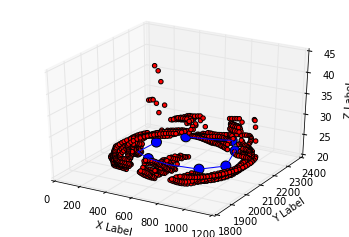

In [53]:
coords1, actions1, labels1, centers1 = load_and_process_data('q3dm1-path1.csv') 
states1 = SOM(coords1, n_states, coords1.shape[0], 100)  

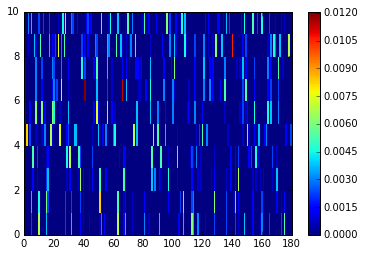

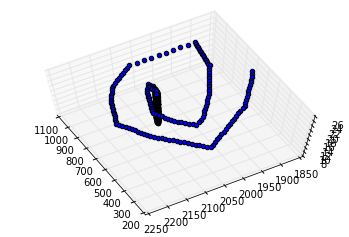

In [54]:
probs1 = calculate_probabilities(coords1, actions1, labels1, states1)
plot_probs(probs1)
traj1 = generate_trajectory(coords1, actions1, states1, labels1, probs1, centers1)
plot_3d(traj1)

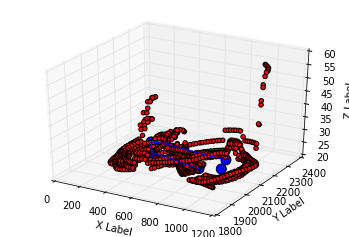

In [55]:
coords2, actions2, labels2, centers2 = load_and_process_data('q3dm1-path2.csv') 
states2 = SOM(coords2, n_states, coords2.shape[0], 100)

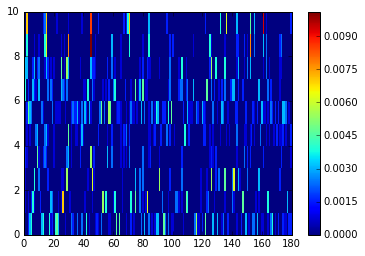

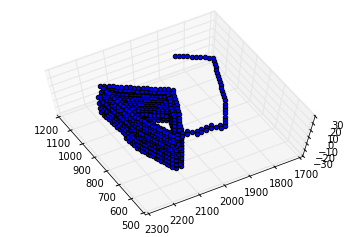

In [59]:
probs2 = calculate_probabilities(coords2, actions2, labels2, states2)
plot_probs(probs1)
traj2 = generate_trajectory(coords2, actions2, states2, labels2, probs2, centers2)
plot_3d(traj2)